In [1]:
%load_ext autoreload
%autoreload 2 
%matplotlib inline

# Set path to find modelling tools for later use
import os
import sys
sys.path.append(os.path.join(os.getcwd(),".."))


from haberrspd.preprocess import preprocessMJFF
                         
import pandas as pd
import re
import numpy as np
print(np.__version__)
from collections import Counter, defaultdict
import itertools
from operator import itemgetter
from scipy.stats import (gamma, lognorm, gengamma)

from pathlib import Path
from IPython.display import display

# Plot stuff
import seaborn as sns
from scipy.constants import golden
import matplotlib.pyplot as plt
plt.style.use('dark_background')


data_root = '../data/MJFF/' # My local path
data_root = Path(data_root)

1.16.4


----

# Character + Timing data

In [ ]:
proc = preprocessMJFF()

In [ ]:
out = proc('all')

In [ ]:
out.to_csv("../data/MJFF/preproc/EnglishSpanishData-preprocessed.csv",index=False)

In [ ]:
out = proc('spanish')

In [ ]:
out.to_csv("../data/MJFF/preproc/SpanishData-preprocessed.csv",index=False)

In [ ]:
out = proc('english')

In [ ]:
out.to_csv("../data/MJFF/preproc/EnglishData-preprocessed.csv",index=False)

In [ ]:
pwd

In [ ]:
out[out['Preprocessed_typed_sentence'].apply(lambda x: len(x) > 10000)]

In [ ]:
# df = pd.read_csv(data_root / 'SpanishData-duplicateeventsremoved.csv')
df = pd.read_csv(data_root / 'SpanishData.csv')
df_meta = pd.read_csv(data_root / "SpanishParticipantKey.csv",
                      index_col=0,
                      header=0,
                      names=['participant_id', 'diagnosis'])

# Character ONLY data

In [ ]:
proc = preprocessMJFF()

In [ ]:
out = proc('english',include_time=False)

In [ ]:
out.head()

In [ ]:
out[out['Preprocessed_typed_sentence'].apply(lambda x: len(x) < 30)]

In [ ]:
out.to_csv("../data/MJFF/preproc/char/EnglishSpanishData-preprocessed.csv",index=False)

## PLOT


In [ ]:
controls = set(df_meta.loc[df_meta.diagnosis == 0].participant_id)
pd_subjects = set(df_meta.loc[df_meta.diagnosis == 1].participant_id)

In [ ]:
pd_timestamp_diffs = []
# Loop over all subjects
for sub in pd_subjects:
    # Get all delta timestamps for this sentence, across all subjects
    pd_timestamp_diffs.extend(df.loc[(df.sentence_id == 57) & (df.participant_id == sub)].timestamp.diff().values)
    
control_timestamp_diffs = []
# Loop over all subjects
for sub in controls:
    # Get all delta timestamps for this sentence, across all subjects
    control_timestamp_diffs.extend(df.loc[(df.sentence_id == 57) & (df.participant_id == sub)].timestamp.diff().values)

In [ ]:
# remove NaNs
pd_cleaned_list = [x for x in pd_timestamp_diffs if str(x) != 'nan']
control_cleaned_list = [x for x in control_timestamp_diffs if str(x) != 'nan']

In [ ]:
# PD

# fixed bin size
bins = np.arange(0, 10000, 50) # fixed bin size
# plt.xlim([min(data)-5, max(data)+5])
fig = plt.figure(figsize=(14,6))
plt.hist(pd_cleaned_list, bins=bins, alpha=0.5)
# plt.vlines(np.quantile(cleaned_list,0.95),0,900,'r')
# plt.vlines(np.mean(cleaned_list),0,900,'b')
plt.grid(True)
plt.show()

In [ ]:
# control

# fixed bin size
bins = np.arange(0, 10000, 50) # fixed bin size
# plt.xlim([min(data)-5, max(data)+5])
fig = plt.figure(figsize=(14,6))
plt.hist(control_cleaned_list, bins=bins, alpha=0.5)
# plt.vlines(np.quantile(cleaned_list,0.95),0,900,'r')
# plt.vlines(np.mean(cleaned_list),0,900,'b')
plt.grid(True)
plt.show()

### Mechanical turk data

In [ ]:
out.to_csv(data_root /'preprocessed_MechanicalTurkCombinedEnglishData.csv',index=False)

In [ ]:
ls ../data/MJFF/

### IKI extraction

In [ ]:
out = create_mjff_iki_training_data(df)

## Keyboard inputs

In [ ]:
from haberrspd.charCNN.data_utils_tf import create_mjff_data_objects, us_standard_layout_keyboard, english_keys_to_2d_coordinates
import keras.backend as K
from keras import callbacks
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from numpy import array, int64, ones, hstack, pad, einsum, dstack
from pandas import read_csv
from sklearn.model_selection import train_test_split
from tensorflow import cast, float32, one_hot
import itertools

In [ ]:
which_information = "char_time_space"
DATA_ROOT = Path("../data/") / "MJFF" / "preproc"
data_string = "EnglishData-preprocessed.csv"
if which_information == "char_time_space":
    # Get relevant long-format data
    which_information = "char_time"

In [ ]:
df = read_csv(DATA_ROOT / which_information / data_string, header=0)  # MJFF data
subject_documents, subjects_diagnoses, alphabet = create_mjff_data_objects(df)

# Store alphabet size
alphabet_size = len(alphabet)

print('Total number of characters:', alphabet_size)
alphabet_indices = dict((c, i) for i, c in enumerate(alphabet))

if which_information == "char_time" or which_information == "char_time_space":
    # Rounds (up) to nearest thousand
    max_sentence_length = round(df.Preprocessed_typed_sentence.apply(lambda x: len(x)).max(), -3)
if which_information == "char":
    # Rounds (up) to nearest hundred
    max_sentence_length = round(df.Preprocessed_typed_sentence.apply(lambda x: len(x)).max(), -2)

# Make training data array
all_sentences = [item for sublist in subject_documents for item in sublist]

In [ ]:
# Initialise tokenizer which maps characters to integers
tk = Tokenizer(num_words=None, char_level=True)

# Fit to text: convert all chars to ints
tk.fit_on_texts(all_sentences)

# Update alphabet
tk.word_index = alphabet_indices

# Get integer sequences: converts sequences of chars to sequences of ints
int_sequences = tk.texts_to_sequences(all_sentences)

# Pad sequences so that they all have the same length and then one-hot encode
X = to_categorical(pad_sequences(int_sequences, maxlen=max_sentence_length, padding='post'))

In [ ]:
X.shape

In [ ]:
which_information  =  'char_time_space'
if which_information == 'char_time_space':
    # Load relevant keyboard
    keyboard = us_standard_layout_keyboard()  # OBS: nested list
    # Check that all chars are in fact in our "keyboard" -- if not, we cannot map a coordinate
    assert alphabet.issubset(set(list(itertools.chain.from_iterable(keyboard))))
    space = [english_keys_to_2d_coordinates(sentence, keyboard) for sentence in all_sentences]
    space_padded = [pad(s, [(0, max_sentence_length - len(s)), (0, 0)], mode='constant') for s in space]
    # Append coordinates to one-hot encoded sentences
    X = einsum('ijk->kij', dstack([hstack((x, s)) for (x, s) in zip(X, space_padded)]))

In [ ]:
X.shape

# Document (participant) -level classification

Three options (at time of writing):

1. Submit each sentence to model and extract classification probability for each sentence, agglomorate at the end, and the conduct a classification on the vector of all 15 probabilities.
2. Calculate the expected value of all encoded (15) sentences and then pass this to the model and take the classification.
3. Vertically stack all embedded sentences, and let the convolution run over this (very long) array.

In [ ]:
from haberrspd.charCNN.data_utils_tf import create_training_data_keras, create_mjff_data_objects
from pandas import read_csv

In [ ]:
which_information = "char_time"
DATA_ROOT = Path("../data/") / "MJFF" / "preproc"
data_string = "EnglishData-preprocessed.csv"
df = read_csv(DATA_ROOT / which_information / data_string, header=0)  # MJFF data
# subject_documents, subjects_diagnoses, alphabet = create_mjff_data_objects(df)
# X_train, X_test, y_train, y_test, max_sentence_length, alphabet_size = create_training_data_keras(DATA_ROOT, which_information, data_string)

In [ ]:
df.head()

In [ ]:
for doc in subject_documents[:3]:
    print(doc[:2])
    print('\n')

# MRC data

In [127]:
# Set path to find modelling tools for later use
import os
import sys
sys.path.append(os.path.join(os.getcwd(),".."))

import pandas as pd
from pathlib import Path
from haberrspd.preprocess import (clean_mrc,
                                  sentence_level_pause_correction,
                                  backspace_corrector, 
                                  flatten,
                                  calculate_edit_distance_between_response_and_target_MRC)
from haberrspd.charCNN.data_utils_tf import us_english_keyboard_mrc
from numpy import concatenate
from typing import Tuple
import random
import matplotlib.pyplot as plt
import numpy as np
numpy.set_printoptions(threshold=sys.maxsize)

from itertools import compress, count, groupby
from operator import itemgetter
import copy

# Monster machine
data_root = Path('../data/MRC/')

In [17]:
df = pd.read_csv(data_root / "CombinedTypingDataNov21-duplicateeventsremoved.csv", header=0)

/home/nd/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Remove duplicates

Some entries (indexed by the pair subject and sentence) have multiple copies of the same typed sentence stored onto the same index. This section removes those duplicates and stores a new file which has one unique typed sentence per index.

In [ ]:
from haberrspd.preprocess import remove_superfluous_reponse_id_rows

In [15]:
# Load file CombinedTypingDataSept27.csv as df

# Run
# remove_superfluous_reponse_id_rows(df)

# Save
# df.to_csv(data_root / "CombinedTypingDataNov21-duplicateeventsremoved.csv",index=False)

### Clean dataframe

In [18]:
out = clean_mrc(df)

Removal of sentences with 'high' Levenshtein distance...

Size of dataframe before row pruning: (790643, 12)
Size of dataframe after row pruning: (790148, 12)

Removal of sentences with left/right arrows keys...

Size of dataframe before row pruning: (790148, 12)
Size of dataframe after row pruning: (758744, 12)


In [19]:
# df = pd.read_pickle(Path('../data/MRC/') / 'cleaned_mrc.pkl')
# In-place dropping of keyup rows
df.drop(df.index[(df.type == "keyup")], inplace=True)
# Reset index so that we can sort it properly in the next step
df.reset_index(drop=True, inplace=True)

In [84]:
all_IKI_R_calc = defaultdict(list)
ii = 0
for i in range(len(df))[1:]:
    if (df.loc[i-1, "sentence_id"] == 1) == (df.loc[i, "sentence_id"] == 1) & (df.loc[i-1,"participant_id"] == df.loc[i,"participant_id"]):
        # Same sentence ID and same participant ID
        all_IKI_R_calc[df.loc[i,"participant_id"]].append(df.loc[i, "timestamp"] - df.loc[i-1, "timestamp"])

In [ ]:
all_IKI_R_calc.keys()

In [119]:
from scipy.stats import norm

In [142]:
stat = defaultdict(dict)
# Loop over all subjects which have typed this sentence
for sent in df.sentence_id.unique():
    tmp = []
    for subject in df.loc[(df.sentence_id == sent)].participant_id.unique():
        # Get all delta timestamps for this sentence_level_pause_correction, across all subjects
        bajs = df.loc[(df.sentence_id == sent) & (df.participant_id == subject)].timestamp.diff()[1:]
        # Append to get statistics over all participants
        tmp.extend(bajs)
    stat[sent] = (np.percentile(np.array(tmp),99,interpolation='lower'),len(tmp))

stat

defaultdict(dict,
            {1: (2064.0, 20810),
             2: (2000.0, 18762),
             3: (1790.6949999739882, 22887),
             4: (1823.900000017995, 19049),
             5: (1680.0000000519503, 18513),
             6: (1719.809999922989, 28298),
             7: (1572.100000000035, 27566),
             8: (1718.0899999809917, 29777),
             9: (1919.82499999, 29700),
             10: (1656.0, 23966),
             11: (1806.8749999989523, 25706),
             12: (1615.9450000000652, 31414),
             13: (1687.0, 30449),
             14: (1538.3649999999907, 24306),
             15: (1600.5, 29108)})

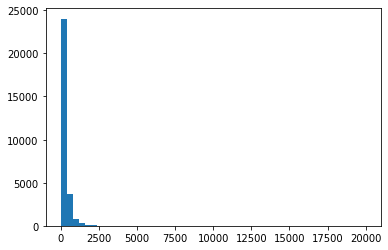

In [147]:
plt.hist(np.array(tmp),bins=50)
plt.show()

In [25]:
out = sentence_level_pause_correction(df)
out[1]

{1: (1306.4601992895189, 312.5746008904562),
 2: (1364.8994170364967, 328.6095374940683),
 3: (1182.4900805574543, 318.0734980952354),
 4: (1262.980299303649, 321.35385545801665),
 5: (1772.3117371819153, 413.46921513134305),
 6: (1306.229145699725, 312.6193342933887),
 7: (1079.251618715184, 293.5182280849008),
 8: (1149.9267595651233, 299.9284354804538),
 9: (1239.7947729204416, 317.64031188000985),
 10: (1180.9260877541903, 299.4039406664668),
 11: (1205.0930181731587, 297.0645406615338),
 12: (1100.975547571192, 296.35147347976505),
 13: (1169.4416477479342, 296.679986942157),
 14: (1004.799480000814, 288.0282207162526),
 15: (1025.509363768798, 291.13882435869743)}

---

In [21]:
out = clean_mrc(df)
# out.head()
# df = copy.copy(out)
# Pickle processed data
out.to_pickle(data_root / 'processed_mcr.pkl')

Removal of sentences with 'high' Levenshtein distance...

Size of dataframe before row pruning: (790643, 12)
Size of dataframe after row pruning: (790148, 12)

Removal of sentences with left/right arrows keys...

Size of dataframe before row pruning: (790148, 12)
Size of dataframe after row pruning: (758744, 12)


In [63]:
# Unpickle stored file
df = pd.read_pickle(data_root / 'processed_mcr.pkl')

# Protocol to process the MRC data

1. A form of `create_char_compression_time_mjff_data` [to get the temporal data] <-- this needs to be set so that we get a list of 
2. Second use `create_dataframe_from_processed_data`

In [2]:
from haberrspd.preprocess import (combine_contiguous_shift_keydowns_without_matching_keyup, 
                                  assess_repeating_key_compression_pattern, 
                                  remove_solitary_key_presses,
                                  sentence_level_pause_correction,
                                  make_character_compression_time_sentence_mrc)
from collections import defaultdict
from itertools import count 
pd.options.mode.chained_assignment = None  # default='warn'
# Baseline
from haberrspd.preprocess_baseline import calculate_iki_and_ed_baseline, reference_sentences

In [3]:
import pickle
import os.path

## IKI and ED baseline calculations

MRC

In [4]:
df = pd.read_pickle(Path('../data/MRC/') / 'processed_mcr.pkl')
out = sentence_level_pause_correction(df)
output = open(data_root / 'sentence_level_pause_correct_mrc.pkl', 'wb')
pickle.dump(out, output)

In [5]:
os.path.exists(data_root / 'sentence_level_pause_correct_mrc.pkl')

True

MJFF

In [80]:
data_root = Path("../data/")
df = pd.read_csv(data_root / 'MJFF' / 'raw' / 'EnglishData-duplicateeventsremoved.csv')

out = sentence_level_pause_correction(df)

output = open(data_root / 'sentence_level_pause_correct_mjff.pkl', 'wb')
# pickle.dump(mydict, output)
pickle.dump(out, output)

## Compression times attempt

In [8]:
def create_sentences_from_raw_typing_mrc(df: pd.DataFrame, 
                                          make_long_format=True,
                                          time_redux_fact=10) -> Tuple[dict, list]:

    fail = 0
    success = 0
    corrected_sentences = defaultdict(dict)
    broken_sentences = defaultdict(dict)
    char_compression_sentences = defaultdict(dict)
    for subj_idx in df.participant_id.unique():
        # Not all subjects have typed all sentences hence we have to do it this way
        print("\n\t>>>This is subject: %i." % subj_idx)
        for sent_idx in df.loc[(df.participant_id == subj_idx)].sentence_id.unique():
            print(sent_idx, end=" ")
            
            # Locate df segment to extract
            coordinates = (df.participant_id == subj_idx) & (df.sentence_id == sent_idx)

            # Store temporary dataframe because why not
            df_view = df.loc[coordinates, ("key", "timestamp", "type")].reset_index(drop=True).copy()  # Reset index

            # Action order:
            #     2. Remove contiguous shifts
            #     0. Sort dataset
            #     1. Implement backspaces
            #     (3. Remove solitary keys)

            # Removes contiguous shift presses
            df_view = combine_contiguous_shift_keydowns_without_matching_keyup(df_view)
            
            # Get correctly ordered sentences and total compression times
            df_view = move_keys_to_temporal_monotonically_increasing_order(df_view)

            # Method to 'implement' the users' backspace actions
            new_backspace_implementer_mrc(df_view)

            if [i for i in Counter(df_view.key).most_common() if i[1] % 2 != 0]:
                # Remove solitary key-presses which do not have a matching keyup or keydown
                remove_solitary_key_presses(df_view) # TODO: not sure if we need this.

            # Check what we managed to achieve
            if assess_repeating_key_compression_pattern(df_view.type.tolist()):

                # Condition succeeds: data-collection is fixed
                corrected_sentences[subj_idx][sent_idx] = df_view
                success += 1

            else:

                # Condition fails: data-collection is broken
                broken_sentences[subj_idx][sent_idx] = df_view
                fail += 1
                print("\n\t[broken sentence] Participant: {}, Sentence: {}".format(subj_idx, sent_idx))
                
        print()

#     for subj_idx in corrected_sentences.keys():
#         # Not all subjects have typed all sentences hence we have to do it this way
#         for sent_idx in corrected_sentences[subj_idx].keys():
#             if make_long_format:
#                 # Final long-format sentences stored here
#                 char_compression_sentences[subj_idx][sent_idx] = "".join(
#                     make_character_compression_time_sentence_mrc(
#                         corrected_sentences[subj_idx][sent_idx], time_redux_fact=time_redux_fact
#                     )
#                 )
#             else:
#                 # We do not use the time-dimension and look only at the spatial component
#                 # Final long-format sentences stored here
#                 char_compression_sentences[subj_idx][sent_idx] = "".join(
#                     corrected_sentences[subj_idx][sent_idx].key[::2]
#                 )  # [::2] takes into account that we only want one of the keydown-keyup pair.

    print("Percentage failed: {}".format(round(100 * (fail / (success + fail)), 2)))
    print(fail, success)

    return char_compression_sentences, broken_sentences

In [9]:
new = create_sentences_from_raw_typing_mrc(df)


	>>>This is subject: 1010.
1 2 5 3 4 6 7 8 9 10 11 12 13 14 15 

	>>>This is subject: 1011.
1 2 5 3 4 6 7 8 9 10 11 12 
	[broken sentence] Participant: 1011, Sentence: 12
13 14 
	[broken sentence] Participant: 1011, Sentence: 14


	>>>This is subject: 1012.
1 2 5 3 
	[broken sentence] Participant: 1012, Sentence: 3
4 6 
	[broken sentence] Participant: 1012, Sentence: 6
7 8 9 10 11 
	[broken sentence] Participant: 1012, Sentence: 11
12 13 14 15 

	>>>This is subject: 1014.
1 2 5 3 4 6 
	[broken sentence] Participant: 1014, Sentence: 6
7 8 9 10 11 12 13 14 15 

	>>>This is subject: 1013.
1 2 5 3 4 6 7 9 10 11 12 13 14 15 

	>>>This is subject: 1015.
1 2 5 3 4 6 7 8 9 10 11 12 13 14 15 

	>>>This is subject: 1019.
1 2 5 3 4 6 7 8 9 10 11 12 13 14 15 

	>>>This is subject: 1016.
1 2 5 3 4 6 7 8 9 10 11 12 13 14 15 

	>>>This is subject: 1018.
1 2 5 3 4 6 7 8 9 10 11 12 13 14 15 

	>>>This is subject: 1020.
1 2 5 3 4 6 7 8 9 10 12 
	[broken sentence] Participant: 1020, Sentence: 12
13 14 1

AssertionError:     key  timestamp     type
129   α   728770.0    keyup
130   α   729425.0  keydown
131   α   729597.0    keyup

In [11]:
df.participant_id.unique()

array([1010, 1011, 1012, 1014, 1013, 1015, 1019, 1016, 1018, 1020, 1022,
       1021, 1024, 1023, 1026, 1025, 1027, 1030, 1031, 1033, 1034, 1035,
       1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047,
       1048, 1049, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1059, 1063,
       1064, 1065, 1066, 1067, 1068, 1069, 1071, 1070, 1072, 1073, 1074,
       1075, 1077, 1078, 1076, 1079, 1081, 1080, 1082, 1084, 1083, 1085,
       1086, 1087, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098,
       1099, 1100, 1104, 1108, 1106, 1109, 1110, 1111, 1113, 1117, 1119,
       1120, 1121, 1122, 1123, 1124, 1128, 1126, 1125, 1129, 1127, 1131,
       1130, 1137, 1133, 1134, 1138, 1135, 1140, 1141, 1139, 1142, 1143,
       1144, 1146, 1145, 1149, 1148, 1150, 1151, 1152, 1153, 1154, 1156,
       1157, 1158, 1159, 1160, 1161, 1162, 1163, 1165, 1166, 1167,   11,
         12,   13,   17,   18,   19,   20,   25,   27,   28,   29,   30,
         31,   32,   33,   26,   34,   36,   37,   

## Fix the sorting mechanism

In [7]:
def remove_solitary_key_presses(df, verbose=False):

    suspect_keys = []
    for key, value in Counter(df.key.tolist()).items():
        if value % 2 != 0:
            # Find all keys which appear an unequal number of times
            suspect_keys.append(key)

    # Do not remove "correction identifier key" i.e. €, backspace
    suspect_keys = [key for key in suspect_keys if key not in {"€", "α"}]

    if verbose:
        print(suspect_keys)

    # Find all instances of suspect keys in df
    if len(suspect_keys) != 0:
        indices_to_keep = []
        all_idxs = []
        for key in suspect_keys:
            idxs = df.loc[df.key == key].index
            all_idxs.extend(idxs)
            # If there is more than one such key
            for pair in list(zip(idxs, idxs[1:]))[::2]:
                if pair[1] - pair[0] == 1:
                    indices_to_keep.extend(pair)

        # Take set difference to find what's left
        indices_to_remove = list(set(all_idxs) - set(indices_to_keep))

        # In-place operation, no need to return anything. Cannot reset index at this point.
        df.drop(df.index[indices_to_remove], inplace=True)
        # Reset index so that we can sort it properly in the next step
        df.reset_index(drop=True, inplace=True)
        
def find_all_backspace_groups(df, backspace_char = "α"):
    ids = df.index[(df.key == backspace_char)].tolist()
    groups = []
    for k, g in groupby(enumerate(sorted(ids)), lambda ix: ix[1] - ix[0]):
        groups.append(list(map(itemgetter(1), g)))
    
    return groups

def lookup(v, 
           d={}, 
           c=count()):
    if v in d:
        return d.pop(v)
    else:
        d[v] = next(c)
    return d[v]


def reorder_key_timestamp_columns_mrc(df: pd.DataFrame):
    # Use lookup function to extract the next row-order
    df["new_row_order"] = df.key.map(lookup)
    return df.sort_values(by="new_row_order", kind="mergesort").drop("new_row_order", axis=1).reset_index(drop=True)


def move_keys_to_temporal_monotonically_increasing_order(df:pd.DataFrame) -> pd.DataFrame:
    
    # 1. Remove singular characters [in-place operation]
    remove_solitary_key_presses(df) # Does not operate on backspaces or indicators
    
    # 2. hide/mask blocks of backspaces and don't re-order these, and then insert them again after the re-order
    blocks = [i for i in find_all_backspace_groups(df, "α") if len(i) > 2]
    if len(blocks) != 0:
        proper_sorted = []
        if len(blocks) == 1:
            proper_sorted.append(reorder_key_timestamp_columns_mrc(df.iloc[0:blocks[0][0]]))
            proper_sorted.append(df.iloc[blocks[0]])
            proper_sorted.append(reorder_key_timestamp_columns_mrc(df.iloc[blocks[0][-1]+1:]))
        else:
            i = 0
            for block in blocks:
                # Character blocks to be re-ordered
                proper_sorted.append(reorder_key_timestamp_columns_mrc(df.iloc[i:block[0]]))
                # Backspaces blocks to be left as is
                proper_sorted.append(df.iloc[block])
                # Store the coordinate of last index in the backspace block
                i = block[-1]+1
            # Append the text block
            proper_sorted.append(reorder_key_timestamp_columns_mrc(df.iloc[i:]))
            
        # Recombine all blocks and return
        return pd.concat(proper_sorted, ignore_index=True)
        
    else:
        # No contiguous blocks, so sort as usual
        return reorder_key_timestamp_columns_mrc(df)

def indicate_single_and_double_backspaces(df):
    # 0) Remove any singular backspaces that appear bc. data-reading problems
    remove = []
    groups = find_all_backspace_groups(df)
    
    # Only remove ones which are actually only of list length 1
    for g in groups:
        # Data-reading error
        if len(g) == 1:
            remove.extend(g)
        # We replace these inline so we don't have to do it later
        elif len(g) == 2:
            # Place indicators [keydown]
            df.loc[g[0], "key"] = "€"
            # Place indicators [keyup]
            df.loc[g[1], "key"] = "€"
            
######### Neil [15/11/19] : we do not need this right now but will keep it anyway
#         else:
#             # This line checks if a backspace (keydown,keyup) is included in a contiguous sequence
#             t = df.loc[g,'type'].tolist()
#             for i, pair in enumerate(list(zip(t, t[1:]))):
#                 if df.loc[g[i-1],'type'] != 'keydown':
#                     if pair == ('keydown', 'keyup') or pair == ('keyup', 'keydown'):
#                         # Place indicators [keydown]
#                         df.loc[g[i], "key"] = "€"
#                         # Place indicators [keyup]
#                         df.loc[g[i+1], "key"] = "€"

    if remove:
        # In-place droppping of rows with only one backspace
        df.drop(df.index[remove], inplace=True)
        # Reset index so that we can sort it properly in the next step
        df.reset_index(drop=True, inplace=True)
        
        
def remove_backspace_keyup(df, backspace_char):
    
    idxs_up = df.index[(df.key == backspace_char) & (df.type == "keyup")].tolist()
    # Copy these rows for later use
    df_keyup = df.iloc[idxs_up].copy(deep=True)
    # In-place dropping of these rows
    df.drop(df.index[idxs_up], inplace=True)
    # Reset index so that we can sort it properly in the next step
    df.reset_index(drop=True, inplace=True)
    
    return df_keyup

def find_remaining_backspace_keydown(df, backspace_char):
    
    idxs = df.index[(df.key == backspace_char) & (df.type == "keydown")].tolist()
    contiguous_groups = []
    for k, g in groupby(enumerate(sorted(idxs)), lambda ix: ix[1] - ix[0]):
        contiguous_groups.append(list(map(itemgetter(1), g)))
        
    return contiguous_groups

### New functions for analysis

In [6]:
#### NEW FUNCTIONS

def new_indicate_single_and_double_backspaces(df):
    
    # 0) Remove any singular backspaces that appear bc. data-reading problems
    remove = []
    groups = find_all_backspace_groups(df)
    
    # Only remove ones which are actually only of list length 1
    for g in groups:
        # Data-reading error
        if len(g) == 1:
            remove.extend(g)
        # We replace these inline so we don't have to do it later
        elif len(g) == 2:
            # Place indicators [keydown]
            df.loc[g[0], "key"] = "€"
            # Place indicators [keyup]
            df.loc[g[1], "key"] = "€"
    
    # Return the indices to remove so we can add to this list during processing
    return remove 

def find_timestamp_in_index_range(df_view, key_type, which_extreme):
    
    # 1. We want the smallest timestamp for any df_view when looking at keydown
    # 2. We want the largest timestamp for any df_view when looking at keyup
    
    # df_view is an already sub-indexed view of the larger matrix
    
    assert key_type in ['keydown','keyup']
    assert which_extreme in ['min','max']
    assert df_view.shape[0] < 100  # It is highly unlikely that someone has pressed backspace this much
    
    if which_extreme == 'min':
        assert key_type == 'keydown', key_type
        return df_view.loc[(df_view.type == key_type), 'timestamp'].min()
    else:
        assert key_type == 'keyup', key_type
        return df_view.loc[(df_view.type == key_type), 'timestamp'].max()
    
    
def new_range_extend_mrc(start, length) -> list:
    """
    start: is the top index of what is being removed
    length: is the total length of what is being removed (backwards),
            it is the length of backspace+keydown sequence but only n-1 of them
    """    
    # Need to assert that this is given a sequentially ordered array
    out = list(range(start - 2 * length, start - length)) + list(range(start - length, start)) + list(range(start,start-length))
    assert np.diff(out).sum() == len(out) - 1, (start, length, out)
    return out

def get_coordinate_of_first_backspace_keydown_in_view(df_view, backspace_char = 'α'):
    # Get the index of the first backspace+keydown
    idx = df_view.loc[(df_view.type == 'keydown') & (df_view.key == backspace_char)].index[0]
    if df_view.loc[idx].type == 'keydown':
        # This means that the backspace sequence correctly starts with a keydown
        return idx
    elif df_view.loc[idx].type == 'keyup':
        # This means that the backspace sequence is unsorted and we simply take the first index
        return df_view.loc[(df_view.key == backspace_char)].index[0]
    else:
        raise ValueError

def new_backspace_implementer_mrc(df, backspace_char = 'α'):
    
    # XXX This function assumes that df has already been sorted properly using the new method.
    
    indices_to_remove = new_indicate_single_and_double_backspaces(df)
    
    # Find all larger groups 
    big_contiguous_groups = find_all_backspace_groups(df)
    
    # Filter, in case single backspace indices are still present
    big_contiguous_groups = [i for i in big_contiguous_groups if i[0] not in indices_to_remove]
    
    if big_contiguous_groups:
    
        """
        How it works:
        
        1. Get the coordinate of the first backspace in the sequence (index 0)
        2. Get the total count of number of backspace+keydowns in the sequence (this will account for hold-down sequence and tapping sequences)
           this takes into account that we only want the n-1 backspaces
        """
        
        # Loop over all found groups
        for g in big_contiguous_groups:
            
            # For simplicity we save this as an array view
            df_view = df.loc[g]
            
            # Index of the first backspace
            idx_first_backspace = get_coordinate_of_first_backspace_keydown_in_view(df_view)
            
            if idx_first_backspace == 0:
                # Special case when a sentence starts with backspaces

                assert idx_first_backspace == g[0], (idx_first_backspace, g[0])
                
                # Assign global start indicator
                assert df_view.loc[df_view.index[0]].type == 'keydown'
                start_timestamp = find_timestamp_in_index_range(df_view,'keydown','min')
                df.loc[g[0], ("key", "timestamp", "type")] = ["€", start_timestamp, "keydown"]
                # Assign global end indicator
                assert df_view.loc[df_view.index[-1]].type == 'keyup'
                end_timestamp = find_timestamp_in_index_range(df_view,'keyup','max')
                df.loc[g[-1], ("key", "timestamp", "type")] = ["€", end_timestamp, "keyup"]                
                
                # Append the indices that we remove at the very end
                indices_to_remove.extend(g[1:-1])
                
            else:            
                # Select only the n-1 backspaces [assumption: backspace keyups are masked at this stage]
                tmp = df_view.loc[(df_view.key == backspace_char) & (df_view.type == 'keydown')]
                length_backspace_keydowns = len(tmp) -1
                assert length_backspace_keydowns != 0, df_view
                # Indices to manipulate including g
                first_half = new_range_extend_mrc(idx_first_backspace, length_backspace_keydowns)
                if any(i < 0 for i in first_half):
                    first_half = list(filter(lambda x: x >= 0, first_half))
                # First half and second half of indices to remove
                gg = sorted(first_half + g)
                # Assign global start indicator
                start_timestamp = find_timestamp_in_index_range(df_view,'keydown','min')
                df.loc[gg[0], ("key", "timestamp", "type")] = ["€", start_timestamp, "keydown"]
                # Assign global end indicator
                end_timestamp = find_timestamp_in_index_range(df_view,'keyup','max')
                df.loc[gg[-1], ("key", "timestamp", "type")] = ["€", end_timestamp, "keyup"]
            
                # Append the indices that we remove at the very end
                indices_to_remove.extend(gg[1:-1])
        
        # Remove all duplicate indices, drop the unique ones and reset index
        df.drop(df.index[list(set(indices_to_remove))], inplace=True)
        df.reset_index(drop=True, inplace=True)
        
    elif indices_to_remove:
        # No contiguous groups to consider, only data-reading backspaces
    
        # Remove all duplicate indices and reset index
        df.drop(df.index[list(set(indices_to_remove))], inplace=True)
        df.reset_index(drop=True, inplace=True)
        
    # Check that the indicators appear in the right places (they must appear in pairs)
    indicator_indices = df.index[(df.key == "€")].tolist()
    for pair in list(zip(indicator_indices, indicator_indices[1:]))[::2]:
        assert pair[1] - pair[0] == 1, indicator_indices
        
    # Final check
    assert backspace_char not in df.key.tolist()

In [78]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    tmp0 = df.loc[(df.participant_id == 1010) & (df.sentence_id == 12), ("key", "timestamp", "type")].reset_index(drop=True)  # Reset index
    #print(tmp0)

In [79]:
find_all_backspace_groups(tmp0)

[[95, 96], [284, 285], [287, 288]]

In [ ]:
tmp0 = move_keys_to_temporal_monotonically_increasing_order(tmp0)
new_backspace_implementer_mrc(tmp0)

In [ ]:
import pdb, traceback, sys

try:
    annoying_fuck = backspace_implementer_mrc(test_df)
except:
    extype, value, tb = sys.exc_info()
    traceback.print_exc()
    pdb.post_mortem(tb)